In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
from matplotlib import pyplot as plt
import random
import math
from functools import reduce

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def read_file(fname):
    lines = []
    with open(fname, 'r') as f: 
        for l in f:
            ls = l.strip().split(',') 
            ls = list(map(float,ls[:-1])) + [ls[-1]] 
            lines.append(ls)
    return lines


In [4]:
class SOM(object):
    
    trained = False
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.3
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))

        self._graph = tf.Graph()
        with self._graph.as_default():
            self._weight_vectors = tf.Variable(tf.random.normal(
                [m * n, dim]))
            self._location_vectors = tf.constant(np.array(
                list(self._neuron_locations(m, n))))
            self._vector_input = tf.placeholder("float", [dim])
            self._iter_input = tf.placeholder("float")

            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weight_vectors, tf.stack(
                    [self._vector_input for i in range(m * n)])), 2), 1)),
                0)

            

            slice_input = tf.pad(tf.reshape(bmu_index, [1]),
                                 np.array([[0, 1]]))
            bmu_loc = tf.reshape(tf.slice(self._location_vectors, slice_input, [1, 2]), [2])


            learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input,
                                                  self._n_iterations))
            _alpha_op = tf.multiply(alpha, learning_rate_op)
            _sigma_op = tf.multiply(sigma, learning_rate_op)

            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self._location_vectors, tf.stack(
                    [bmu_loc for i in range(m * n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(tf.div(tf.cast(
                bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)

            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim])
                for i in range(m * n)])
            weight_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self._vector_input for i in range(m * n)]),
                            self._weight_vectors))
            new_weights_op = tf.add(self._weight_vectors,
                                    weight_delta)
            self._training_op = tf.assign(self._weight_vectors,
                                          new_weights_op)

            # initializes session
            self._sess = tf.Session()

            # initializes variables
            init_op = tf.initialize_all_variables()
            self._sess.run(init_op)

    def _neuron_locations(self, m, n):

        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def train(self, input_vects): #trains the som

        for iter_no in range(self._n_iterations):

            for input_vector in input_vects:
                self._sess.run(self._training_op,
                               feed_dict={self._vector_input: input_vector,
                                          self._iter_input: iter_no})

        # Stores a centroid grid which is easy to retrieve later in the program

        centroid_grid = [[] for i in range(self._m)]
        self._weights = list(self._sess.run(self._weight_vectors))
        self._locations = list(self._sess.run(self._location_vectors))
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weights[i])
        self._centroid_grid = centroid_grid

        self.trained = True

        
    def map_vectors(self, input_vectors):  # Maps each input vector to the relevant neuron in the SOM grid.

        if not self.trained:
            raise ValueError("SOM is not trained yet")

        to_return = []
        for vector in input_vectors:
            min_index = min([i for i in range(len(self._weights))],
                            key=lambda x: np.linalg.norm(vector -
                                                         self._weights[x]))
            to_return.append(self._locations[min_index])

        return to_return


In [9]:
def plot_som():
    colors1 = read_file('iris.txt')
    colors = [q[:-1] for q in colors1]

    width=10
    height=10

    som = SOM(width, height, 4, 100)  
    som.train(colors)

    mapped = som.map_vectors(colors)
    rlist = []
    mlist = []
    for i in range(width):
        ilist = []
        imlist = []
        for i in range(height):
            ilist.append([0,0,0])
            imlist.append({'1':0, '2':0, '3':0})
        rlist.append(ilist)
        mlist.append(imlist)
    flower_colormap = {'1': (1.0, 0.0, 0.0), #red
                       '2': (0.0, 1.0, 0.0), #green
                       '3': (0.0, 0.0, 1.0)} #blue

    def add_to_and_norm(v1, v2):
        vr = [v[0] + v[1] for v in zip(v1, v2)]
        mx = max(vr)
        return [q/mx for q in vr]

    for m, v in zip(mapped, colors1):
        nx = m[0]
        ny = m[1]
        lbl = v[-1]
        rlist[nx][ny] = add_to_and_norm(rlist[nx][ny], flower_colormap[lbl])
        mlist[nx][ny][lbl] += 1
    plt.figure(figsize = (10,10))
    plt.imshow(np.asarray(rlist))  # plots the centroids
    plt.title('Self-Organizing Map U-Matrix on iris dataset.')
    plt.savefig('SOM_U_Matrix.png')
    plt.show()
    return som, mlist

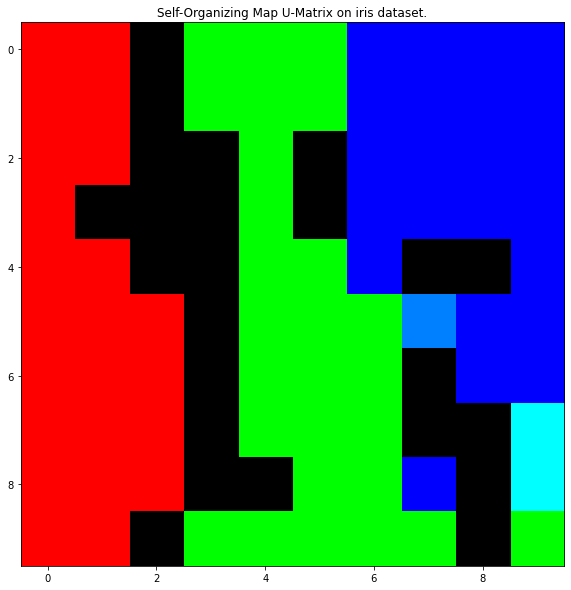

(<__main__.SOM at 0x136a517f0>,
 [[{'1': 3, '2': 0, '3': 0},
   {'1': 1, '2': 0, '3': 0},
   {'1': 0, '2': 0, '3': 0},
   {'1': 0, '2': 2, '3': 0},
   {'1': 0, '2': 3, '3': 0},
   {'1': 0, '2': 1, '3': 0},
   {'1': 0, '2': 0, '3': 2},
   {'1': 0, '2': 0, '3': 1},
   {'1': 0, '2': 0, '3': 3},
   {'1': 0, '2': 0, '3': 5}],
  [{'1': 1, '2': 0, '3': 0},
   {'1': 1, '2': 0, '3': 0},
   {'1': 0, '2': 0, '3': 0},
   {'1': 0, '2': 2, '3': 0},
   {'1': 0, '2': 1, '3': 0},
   {'1': 0, '2': 1, '3': 0},
   {'1': 0, '2': 0, '3': 2},
   {'1': 0, '2': 0, '3': 1},
   {'1': 0, '2': 0, '3': 2},
   {'1': 0, '2': 0, '3': 1}],
  [{'1': 3, '2': 0, '3': 0},
   {'1': 1, '2': 0, '3': 0},
   {'1': 0, '2': 0, '3': 0},
   {'1': 0, '2': 0, '3': 0},
   {'1': 0, '2': 2, '3': 0},
   {'1': 0, '2': 0, '3': 0},
   {'1': 0, '2': 0, '3': 2},
   {'1': 0, '2': 0, '3': 2},
   {'1': 0, '2': 0, '3': 1},
   {'1': 0, '2': 0, '3': 4}],
  [{'1': 3, '2': 0, '3': 0},
   {'1': 0, '2': 0, '3': 0},
   {'1': 0, '2': 0, '3': 0},
   {'1':

In [10]:
plot_som()